In [1]:
%pylab inline
%matplotlib inline
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data import 

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    path = os.path.join(os.getcwd(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with open(path, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [3]:
# NN definition

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.lsm = nn.LogSoftmax(dim=1)
        
    def forward(self, x, **kwargs):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.lsm(x)
        return x

  0%|          | 0/1000 [00:00<?, ?it/s]/home/gaston/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
100%|██████████| 1000/1000 [00:00<00:00, 1102.66it/s]


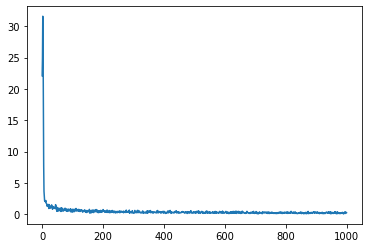

In [4]:
# NN instantiation

model = Classifier()
batch_size = 128
epochs = 1000
loss_function = nn.NLLLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0)

losses = [] # For later plotting

for i in trange(epochs):
    samples_idx = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samples_idx].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samples_idx]).long()
    model.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
    

In [5]:
out_test = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
accuracy = (out_test == Y_test).mean()
accuracy

0.9293

Prediction:  4
Actual value:  4


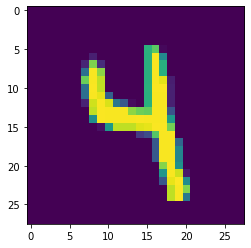

In [6]:
rand_idx = np.random.randint(0, X_test.shape[0])
imshow(X_test[rand_idx])
print('Prediction: ', out_test[rand_idx])
print('Actual value: ', Y_test[rand_idx])

### NO PYTORCH ALLOWED FROM HERE ON

In [7]:
# Layer function definition

import abc

class LayerFunction:
    __metaclass__ = abc.ABCMeta

    def __call__(self, x, **kwargs):
        return self.evaluate(x, **kwargs)
        
    @abc.abstractmethod
    def evaluate(self, x, **kwargs):
        pass
    
    @abc.abstractmethod
    def backprop(self, dD, x):
        pass


# Activation function definition

class ActivationFunction(LayerFunction):
    
    def __init__(self, axis=1):
        self.axis = axis
    

class ReLU(ActivationFunction):
    
    def evaluate(self, x, **kwargs):
        return np.maximum(x, 0)
    
    def backprop(self, dD, x):
        return (x > 0).astype(int)*dD


class LogSoftmax(ActivationFunction):
        
    def evaluate(self, x, **kwargs):
        x = x - x.max(1).reshape(-1, 1)
        x = x - np.log(np.exp(x).sum(1)).reshape(-1, 1)
        return x
            
    def backprop(self, dD, x):
        exp_lsm = np.exp(self.evaluate(x))
        dLSM = dD - exp_lsm*dD.sum(axis=self.axis).reshape((-1, 1))
        return dLSM
    

# Loss function definition

class LossFunction(LayerFunction):

    def __init__(self, axis=0):
        self.axis = axis 
    

class NLLLoss(LossFunction):
    
    def evaluate(self, x, **kwargs):
        if self.axis == 0:
            return -np.mean(x[np.arange(x.shape[0]), kwargs['labels']])
    
    def backprop(self, x, y):
        dx = np.zeros(x.shape, dtype=x.dtype)
        if self.axis == 0:
            dx[np.arange(x.shape[0]), y.T] = -1/len(y)
        return dx
    

class ReconstructionLoss(LossFunction):
    
    def evaluate(self, x, **kwargs):
        target = np.zeros(x.shape, dtype=x.dtype)
        target[:, kwargs['labels']] = 1
        return -np.mean(np.sum((x-target)**2, axis=1))
                        
    def backprop(self, x, y):
        target = np.zeros(x.shape, dtype=x.dtype)
        target[:, y] = 1
        return 2*(x-target)

In [21]:
# Model definition

class NPClassifier:
    def __init__(self, with_biases=False, dtype=np.float32):
        self.with_biases = with_biases
        
        np.random.seed(1111)
        
        # Kaiming weigth initialization
        # Uniform sampling
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
        self.w1 = np.random.uniform(-1., 1., size=(28*28, 128))/np.sqrt(28*28*128).astype(dtype)
        self.w2 = np.random.uniform(-1., 1., size=(128, 10))/np.sqrt(128*10).astype(dtype)
                    
        if with_biases:
            # Uniform bias initialization
            # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
            self.b1 = np.random.uniform(-1., 1., size=(1, 128))/np.sqrt(128).astype(dtype)
            self.b2 = np.random.uniform(-1., 1., size=(1, 10))/np.sqrt(10).astype(dtype)
        
        # Layer activation functions
        self.act1 = ReLU()
        self.act2 = LogSoftmax()
    
    def __call__(self, x):
        return self.forward(x)
    
    @classmethod
    def from_weights(cls, w1, w2, b1=None, b2=None):
        assert w1.shape == (28*28, 128) and w2.shape == (128, 10)
        classifier = cls()
        classifier.w1 = w1
        classifier.w2 = w2
        if b1 is not None and b2 is not None:
            assert b1.shape == (1, 128) and b2.shape == (1, 10)
            classifier.with_biases = True
            classifier.b1 = b1
            classifier.b2 = b2
        return classifier
        
    def forward(self, x):
        x = x.dot(self.w1)
        if self.with_biases:
            x = x + self.b1
        x = self.act1(x)
        x = x.dot(self.w2)
        if self.with_biases:
            x = x + self.b2
        x = self.act2(x)

        return x
    
    def forward_backward(self, x, y, loss_function):
                    
        # Forward pass
        a0 = x
        z1 = a0.dot(self.w1)
        if self.with_biases:
            z1 = z1 + self.b1
        a1 = self.act1(z1)
        z2 = a1.dot(self.w2)
        if self.with_biases:
            z2 = z2 + self.b2
        a2 = self.act2(z2)
        loss = loss_function(a2, labels=y)
                
        # Backward pass
        da2 = loss_function.backprop(a2, y)
        dz2 = self.act2.backprop(da2, z2)
        db2 = dz2.mean(axis=0).reshape(1, 10) # Relevant (returns only if with_biases)
        dw2 = a1.T.dot(dz2) # Relevant
        da1 = dz2.dot(w2.T)
        dz1 = self.act1.backprop(da1, z1)
        db1 = dz1.mean(axis=0).reshape(1, 128) # Relevant (returns only if with_biases)
        dw1 = x.T.dot(dz1) # Relevant
        da0 = dz1.dot(w1.T)
        
        # Return loss and gradients
        return loss, dw1, dw2, db1, db2, da0
    
    def step(self, lr, dw1, dw2, db1=None, db2=None):
        self.w1 = self.w1 - dw1 * lr
        self.w2 = self.w2 - dw2 * lr
        if self.with_biases:
            self.b1 = self.b1 - db1 * lr
            self.b2 = self.b2 - db2 * lr
    
    def train(self, inputs, labels, batch_size, epochs, loss_function, learning_rate):
        losses = []
        for i in trange(epochs):
            samples = np.random.randint(0, inputs.shape[0], size=batch_size)
            loss, dw1, dw2, db1, db2, _ = self.forward_backward(inputs[samples], labels[samples], loss_function)
            losses.append(loss)
            self.step(learning_rate, dw1, dw2, db1, db2)
        return losses
    
    def test(self, inputs, labels):
        forward = np.argmax(self.forward(inputs.reshape((-1, 28*28))), 1).reshape(-1, 1)
        return (forward == labels.reshape(-1, 1)).mean()
        
    def reconstruct(self, label, epochs, loss_function, learning_rate):
        x = (np.random.uniform(-1., 1., size=(1, 28*28))/28 + 128).astype(np.float32)
        label = np.array([label])
        for i in trange(epochs):
            _, _, _, _, _, dx = self.forward_backward(x, label, loss_function)
            x = x - learning_rate * dx
        return x, self(x)
            
        

## PYTORCH V. PYTHON COMPARISON

PyTorch:  [2 1 5 3 9 9 7 3 8 5 9 3 2 9 6 9 0 4 3 5]
Python:   [2 1 5 3 9 9 7 3 8 5 9 3 2 9 6 9 0 4 3 5]
Labels:   [2 1 5 3 9 9 7 3 8 5 9 3 2 9 6 9 0 4 3 3]

Gradient averages 
dw1:  -0.0012908073858252202 db1:  -2.286472138678567e-06 dw2:  1.9499566e-09 db2:  4.3655747e-12 

tensor(0.0906, grad_fn=<MeanBackward0>) 0.09064393


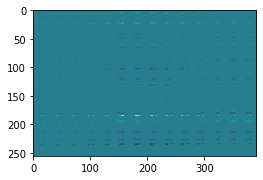

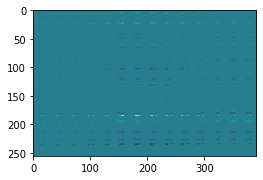

In [22]:
# Model comparison

# Copy Classifier data into NPClassifier
w1 = model.l1.weight.detach().numpy().T
b1 = model.l1.bias.detach().numpy().reshape((-1, 128))
w2 = model.l2.weight.detach().numpy().T
b2 = model.l2.bias.detach().numpy().reshape((-1, 10))
npmodel = NPClassifier.from_weights(w1, w2, b1=b1, b2=b2)

# Compare predictions
n = 20
samples_idx = np.random.randint(0, X_test.shape[0], size=n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped), 1)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

# Gradient of PyTorch trained weights and biases is near 0
loss_function = NLLLoss()
nploss, dw1, dw2, db1, db2, _ = npmodel.forward_backward(X_test_reshaped, Y_test[samples_idx], loss_function)
print('\nGradient averages \ndw1: ', np.average(dw1), 'db1: ', np.average(db1), 'dw2: ', np.average(dw2), 'db2: ', np.average(db2), '\n')

# Gradient equivalence
model.zero_grad()
out = model(torch.tensor(X_test_reshaped).float())
loss_function = nn.NLLLoss(reduction='none')
loss = loss_function(out, torch.tensor(Y_test[samples_idx]).long())
loss = loss.mean()
print(loss, nploss)
loss.backward()

Y_train[samples_idx].shape
figsize(4, 4)
imshow(dw1.T.reshape(256, 28*14))
# imshow(db1.mean(axis=0).reshape(8, 16))
# imshow(dw2.T.reshape(20, 64))
# imshow(db2.mean(axis=0).reshape(1, 10))
# imshow(out_npmodel)
figure()
imshow(model.l1.weight.grad.detach().numpy().reshape(256, 28*14))
# imshow(model.l1.bias.grad.detach().numpy().reshape(8, 16))
# imshow(model.l2.weight.grad.detach().numpy().reshape(20, 64))
# imshow(model.l2.bias.grad.detach().numpy().reshape(1, 10))
# imshow(out_model)


100%|██████████| 1000/1000 [00:01<00:00, 678.52it/s]


Accuracy: 0.9266


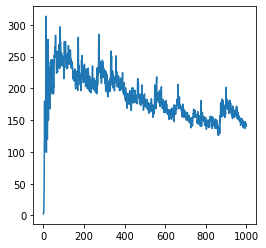

In [23]:
npmodel = NPClassifier()

batch_size = 128
epochs = 1000
learning_rate = 0.001
loss_function = NLLLoss()

inputs = X_train.reshape(-1, 28*28)
labels = Y_train.reshape(-1, 1)

losses = npmodel.train(inputs, labels, batch_size, epochs, loss_function, learning_rate)

figsize(4, 4)
plot(losses)

print(f'Accuracy: {npmodel.test(X_test, Y_test)}')

PyTorch:  [8 4 0 0 9 7 7 6 3 5 9 3 8 1 9 9]
Python:   [8 4 0 0 9 7 7 6 3 5 9 3 8 1 9 9]
Labels:   [8 4 0 0 9 7 7 6 3 3 9 3 8 1 9 9]


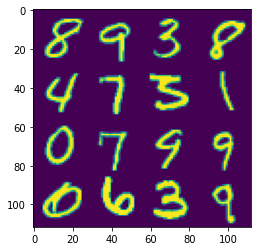

In [26]:
# Compare predictions
n = 4
samples_idx = np.random.randint(0, X_test.shape[0], size=n*n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped), 1)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

figsize(4, 4)
imshow(np.concatenate(X_test[samples_idx].reshape(n, 28*n, 28), axis=1))


# Image reconstruction

100%|██████████| 100/100 [00:00<00:00, 2116.68it/s]


array([8])

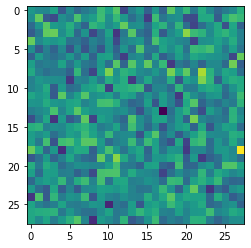

In [12]:
reconstruction_loss = ReconstructionLoss()
sol, res = npmodel.reconstruct(5, 100, reconstruction_loss, 0.1)
imshow(sol.reshape(28, 28))
np.argmax(res, 1)